Plot of the sky brightness on the night sky

In [1]:
import numpy as np 
import astropy.units as u
# -- other -- 
from datetime import datetime
from astroplan import Observer
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS, GCRS, get_sun, get_moon, BaseRADecFrame
# -- feasibgs --
from feasibgs import util as UT
from feasibgs import skymodel as Sky

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
# first lets determine a night sometime next year when the 
# moon is roughly ~30 deg in altitude and has ~0.75 illumination
kpno = EarthLocation.of_site('kitt peak') 
site = Observer(kpno, timezone='UTC')

i_time = 0

for hour in range(4, 12):
    if i_time > 0: continue
    utc_time = Time(datetime(2019, 3, 25, hour, 0, 0)) 
    kpno_altaz = AltAz(obstime=utc_time, location=kpno)
    sun = get_sun(utc_time)
    sun_altaz = sun.transform_to(kpno_altaz)

    moon = get_moon(utc_time)
    moon_altaz = moon.transform_to(kpno_altaz)
    moon_alt = moon_altaz.alt.deg

    elongation = sun.separation(moon)
    phase = np.arctan2(sun.distance * np.sin(elongation), moon.distance - sun.distance * np.cos(elongation))

    moon_ill = (1.+np.cos(phase))/2.

    if (moon_ill > 0.7) and (moon_ill < 0.8) and (moon_alt > 28.) and (moon_alt < 32.): 
        print utc_time
        i_time += 1

2019-03-25 09:00:00


In [4]:
# moon's position during this night
print('azimuth %f, altitude %f' % (moon_altaz.az.deg, moon_altaz.alt.deg))

azimuth 140.643491, altitude 30.516781


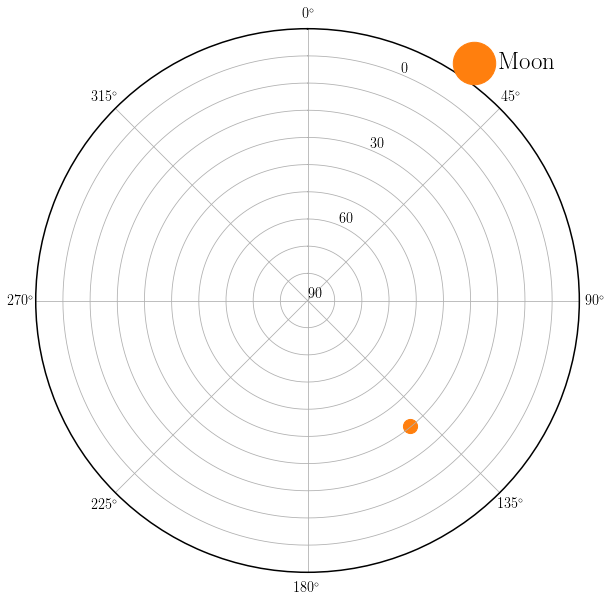

In [5]:
fig = plt.figure(figsize=(10,10))
sub = fig.add_subplot(111, polar=True)
sub.set_theta_zero_location('N')
sub.set_theta_direction(-1)
c = sub.scatter([moon_altaz.az.deg/180.*np.pi], [90.-moon_altaz.alt.deg], c='C1', s=200, label='Moon')
sub.legend(fontsize=25, markerscale=3, handletextpad=0)
sub.set_yticks(range(0, 90+10, 10))
sub.set_ylim([0., 100.])
_ = sub.set_yticklabels([90, '', '', 60, '', '', 30, '', '', 0])
sub.grid(True, which='major')

In [6]:
obj_aa = AltAz(az=140*u.deg, alt=30*u.deg, obstime=utc_time, location=kpno)
obj = SkyCoord(obj_aa)
sky_obj = Sky.skySpec(obj.icrs.ra.deg, obj.icrs.dec.deg, utc_time)
moon = get_moon(utc_time)
moon_altaz = moon.transform_to(kpno_altaz)
print moon.separation(obj).deg
print sky_obj.delm

print moon_altaz.alt.deg
print sky_obj.altm

/Users/chang/anaconda2/lib/python2.7/site-packages/feasibgs/skymodel.py:269: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  coeffs = pd.DataFrame.from_csv(f)


1.4502119369
1.4502119369
30.5167808345
30.5167808345


In [9]:
sky_obj.coeffs.keys()

Index([u'wl', u'model', u'data_var', u'unexplained_var', u' X2', u'rX2', u'c0',
       u'c_am', u'tau', u'tau2', u'c_zodi', u'c_isl', u'sol', u'I', u't0',
       u't1', u't2', u't3', u't4', u'm0', u'm1', u'm2', u'm3', u'm4', u'm5',
       u'm6', u'feb', u'mar', u'apr', u'may', u'jun', u'jul', u'aug', u'sep',
       u'oct', u'nov', u'dec', u'c2', u'c3', u'c4', u'c5', u'c6'],
      dtype='object')

In [9]:
def sky_bright(alt, az, waves=np.linspace(4000., 4500., 10)): 
    obj_aa = AltAz(az=az*u.deg, alt=alt*u.deg, obstime=utc_time, location=kpno)
    obj = SkyCoord(obj_aa)
    sky_obj = Sky.skySpec(obj.icrs.ra.deg, obj.icrs.dec.deg, utc_time)
    sbright = sky_obj.surface_brightness(waves)
    return np.average(np.array(sbright))

In [69]:
def skyMoon_bright(alt, az, waves=[4000., 4500.]): 
    obj_aa = AltAz(az=az*u.deg, alt=alt*u.deg, obstime=utc_time, location=kpno)
    obj = SkyCoord(obj_aa)
    sky_obj = Sky.skySpec(obj.icrs.ra.deg, obj.icrs.dec.deg, utc_time)
    _ = sky_obj.get_Icontinuum()
    wl = 10.*np.array(sky_obj.coeffs['wl'])
    Imoon = np.array(sky_obj._dT * sky_obj._Imoon)
    #Imoon = np.array(sky_obj._Imoon)
    print sky_obj.X, np.average(Imoon[(wl > waves[0]) & (wl < waves[1])])/np.pi
    return np.average(Imoon[(wl > waves[0]) & (wl < waves[1])])/np.pi

In [49]:
az_bins = np.linspace(0., 360., 5)
alt_bins = np.linspace(0., 90., 5)
az_mid = 0.5*(az_bins[1:]+az_bins[:-1])
alt_mid = 0.5*(alt_bins[1:]+alt_bins[:-1])

In [50]:
sb = []
for az in az_mid:
    for alt in alt_mid:
        sbright = sky_bright(alt, az)
        sb.append(sbright)
sb = np.array(sb)

In [70]:
mb = []
for az in az_mid:
    for alt in alt_mid:
        sbright = skyMoon_bright(alt, az)
        mb.append(sbright)
mb = np.array(mb)

5.12583089548 100.24391855262375
1.79995244627 10.26187828033338
1.20268977387 7.085454450723095
1.01959115821 6.396302526287875
5.12583089548 119.73266771837521
1.79995244627 12.914851154026419
1.20268977387 8.052561137654852
1.01959115821 6.624876848608485
5.12583089548 101.30922492154525
1.79995244627 10.41128751851038
1.20268977387 7.178461068695468
1.01959115821 6.430655802782056
5.12583089547 103.07833167054721
1.79995244627 10.10501677978772
1.20268977387 6.850435518905352
1.01959115821 6.267481205013901


In [75]:
obj_aa = AltAz(az=140*u.deg, alt=30*u.deg, obstime=utc_time, location=kpno)
obj = SkyCoord(obj_aa)
sky_obj = Sky.skySpec(obj.icrs.ra.deg, obj.icrs.dec.deg, utc_time)
_ = sky_obj.get_Icontinuum()
print sky_obj._dT

[0.78329392 0.87476555 0.89231193 0.891203   0.90126896 0.89878179
 0.8237024  0.87416783 0.77704075 0.864131   0.88130085 0.84463397
 0.89012871 0.87561492 0.87666427 0.88237904 0.82613119 0.86329647
 0.76633045 0.86880649 0.84388119 0.87643671 0.88264254 0.8552443
 0.85843549 0.8857252  0.87337298 0.89569036 0.83144332 0.90488624
 0.79420534 0.7888392  0.88957223 0.77533436 0.8475832  0.8814811
 0.88180917 0.87848526 0.82281317 0.85442384 0.77875889 0.82836874
 0.86193327 0.88915725 0.8588274  0.88464045 0.79332261 0.89874762
 0.8653215  0.84826966 0.77018818 0.87987833 0.85933116 0.89956186
 0.81598151 0.76260661 0.88981418 0.87988227 0.86595976 0.79600867
 0.88017324 0.83897213 0.89232491 0.89705379 0.86656625 0.8875471
 0.83380577 0.8169506  0.88871417 0.81991518 0.88924534 0.8179381
 0.79155485 0.85143034 0.88169043 0.80459649 0.90084911 0.88841423
 0.81331408 0.89109427 0.78975148 0.78514724 0.89420047 0.90013838
 0.83222329 0.86805625 0.88086729 0.89061591 0.78145987 0.79985814

In [65]:
sb

array([206.08289136,  12.94250736,   8.0585076 ,   7.05461787,
       245.98167579,  16.26143772,   9.18927506,   7.32801976,
       208.29060472,  13.29040603,   8.39456325,   7.16650032,
       211.93247188,  12.84978595,   7.88032368,   6.95011381])

In [66]:
mb

array([100.24391855,  10.26187828,   7.08545445,   6.39630253,
       119.73266772,  12.91485115,   8.05256114,   6.62487685,
       101.30922492,  10.41128752,   7.17846107,   6.4306558 ,
       103.07833167,  10.10501678,   6.85043552,   6.26748121])

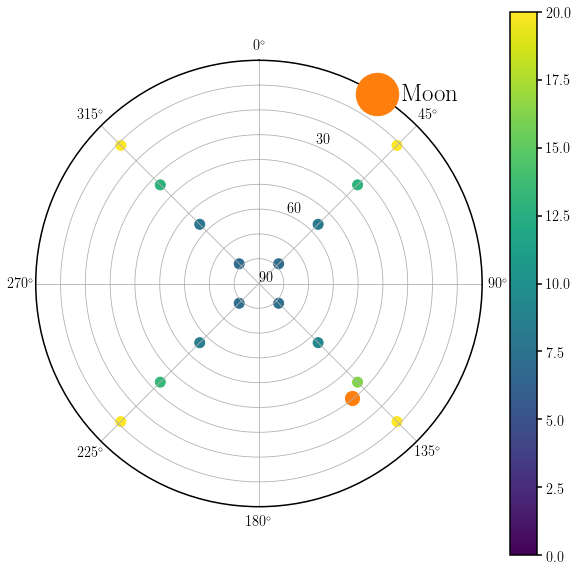

In [62]:
fig = plt.figure(figsize=(10,10))
sub = fig.add_subplot(111, projection='polar')
sub.set_theta_zero_location('N')
sub.set_theta_direction(-1)
sub.scatter([moon_altaz.az.deg/180.*np.pi], [90.-moon_altaz.alt.deg], c='C1', s=200, label='Moon')
phi_grid, r_grid = np.meshgrid(az_mid/180.*np.pi, 90.-alt_mid)
c = sub.scatter(phi_grid.T.flatten(), r_grid.T.flatten(), c=sb, s=100, cmap='viridis', vmin=0., vmax=20.)
#c = sub.scatter(az_bins/180.*np.pi, 90.-alt_bins, c=vals, s=100, cmap='viridis', vmin=0., vmax=20.)
plt.colorbar(c)
sub.legend(fontsize=25, markerscale=3, handletextpad=0)
sub.set_yticks(range(0, 90+10, 10))
sub.set_ylim([0., 90.])
_ = sub.set_yticklabels([90, '', '', 60, '', '', 30, '', '', ''])
sub.grid(True, which='major')

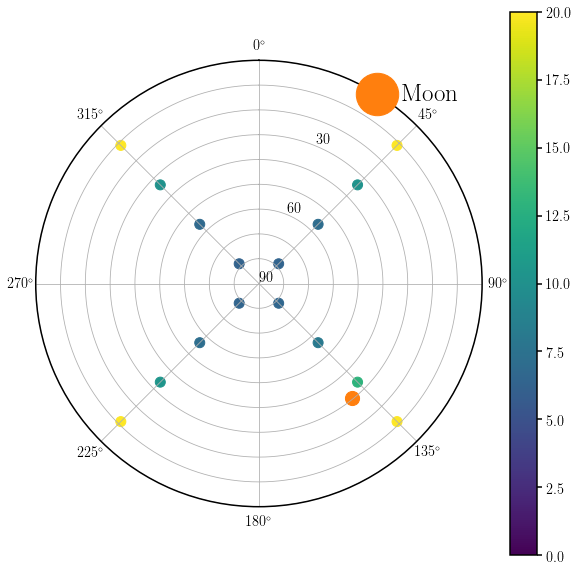

In [53]:
fig = plt.figure(figsize=(10,10))
sub = fig.add_subplot(111, projection='polar')
sub.set_theta_zero_location('N')
sub.set_theta_direction(-1)
sub.scatter([moon_altaz.az.deg/180.*np.pi], [90.-moon_altaz.alt.deg], c='C1', s=200, label='Moon')
phi_grid, r_grid = np.meshgrid(az_mid/180.*np.pi, 90.-alt_mid)
c = sub.scatter(phi_grid.T.flatten(), r_grid.T.flatten(), c=mb, s=100, cmap='viridis', vmin=0., vmax=20.)
#c = sub.scatter(az_bins/180.*np.pi, 90.-alt_bins, c=vals, s=100, cmap='viridis', vmin=0., vmax=20.)
plt.colorbar(c)
sub.legend(fontsize=25, markerscale=3, handletextpad=0)
sub.set_yticks(range(0, 90+10, 10))
sub.set_ylim([0., 90.])
_ = sub.set_yticklabels([90, '', '', 60, '', '', 30, '', '', ''])
sub.grid(True, which='major')

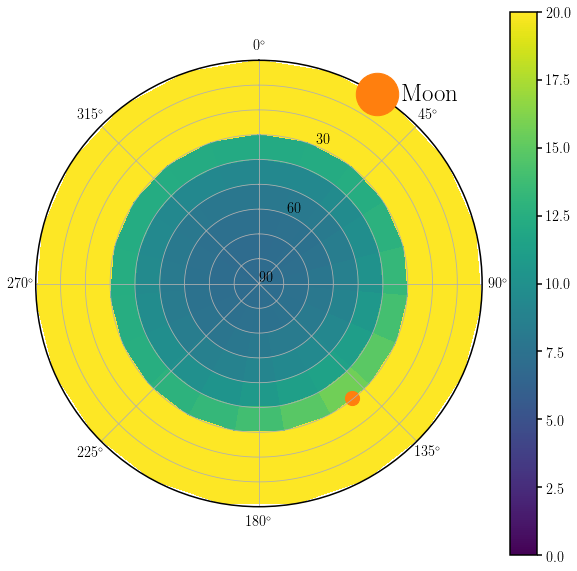

In [26]:
fig = plt.figure(figsize=(10,10))
sub = fig.add_subplot(111, projection='polar')
sub.set_theta_zero_location('N')
sub.set_theta_direction(-1)
phi_grid, r_grid = np.meshgrid(az_bins/180.*np.pi, 90.-alt_bins)
c = sub.pcolormesh(phi_grid.T, r_grid.T, sb.reshape((len(az_mid), len(alt_mid))), cmap='viridis', vmin=0., vmax=20.)
#c = sub.scatter(az_bins/180.*np.pi, 90.-alt_bins, c=vals, s=100, cmap='viridis', vmin=0., vmax=20.)
plt.colorbar(c)
sub.scatter([moon_altaz.az.deg/180.*np.pi], [90.-moon_altaz.alt.deg], c='C1', s=200, label='Moon')
sub.legend(fontsize=25, markerscale=3, handletextpad=0)
sub.set_yticks(range(0, 90+10, 10))
sub.set_ylim([0., 70.])
_ = sub.set_yticklabels([90, '', '', 60, '', '', 30, '', '', ''])
sub.grid(True, which='major')

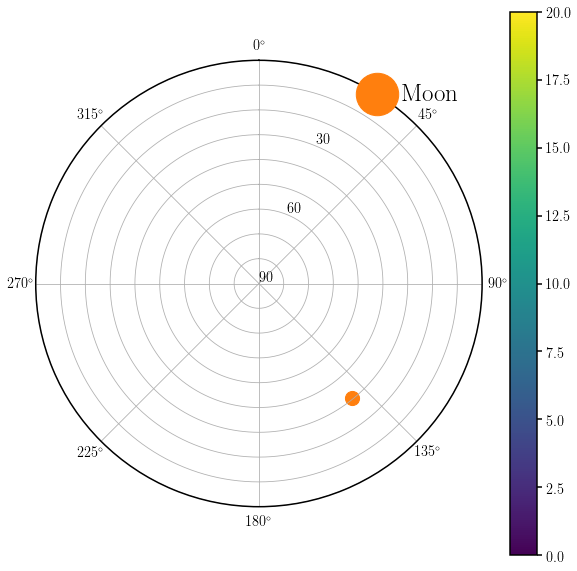

In [34]:
fig = plt.figure(figsize=(10,10))
sub = fig.add_subplot(111, projection='polar')
sub.set_theta_zero_location('N')
sub.set_theta_direction(-1)
phi_grid, r_grid = np.meshgrid(az_bins/180.*np.pi, 90.-alt_bins)
c = sub.pcolormesh(phi_grid.T, r_grid.T, mb.reshape((len(az_mid), len(alt_mid))), cmap='viridis', vmin=0., vmax=20.)
plt.colorbar(c)
sub.scatter([moon_altaz.az.deg/180.*np.pi], [90.-moon_altaz.alt.deg], c='C1', s=200, label='Moon')
sub.legend(fontsize=25, markerscale=3, handletextpad=0)
sub.set_yticks(range(0, 90+10, 10))
sub.set_ylim([0., 90.])
_ = sub.set_yticklabels([90, '', '', 60, '', '', 30, '', '', ''])
sub.grid(True, which='major')